In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import matplotlib.gridspec as gridspec

from scipy.ndimage import label, generate_binary_structure, binary_dilation

import pickle

_nthreads = 2

z1 = 1000. + 250.*np.arange(33)
z2 = 9500. + 500.*np.arange(12)
z3 = 15000. + 1000.*np.arange(4)
zlevels = np.concatenate((z1, z2, z3))

case_days = sorted(["2022050400",
            "2022051200",
            "2022051400",
            "2022051500",
            "2022051900",
            "2022052300",
            "2022052400",
            "2022052700",
            "2022053000",
            "2022060700"])


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def generate_real_profiles(in_dir, day, model_type='wrf', w_thresh = 5.0, cref_thresh = 45., min_pix=5):

    if model_type == 'wrf':
        
        ds   = xr.open_dataset(str(os.path.join(in_dir, "%s_HRRR_ECONUS.nc" % day)))

        w    = ds.w_interp.values
        dbz  = ds.dbz_interp.values
        pres = ds.p_interp.values
        z    = np.broadcast_to(ds.z.values[np.newaxis, :, np.newaxis, np.newaxis], w.shape)

        profiles = compute_obj_profiles(w, dbz, pres, z, w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)
        
        ds.close()

        return profiles
    
    if model_type == 'fv3':
        
        ds   = xr.open_dataset(str(os.path.join(in_dir, "%s_RRFS_ECONUS.nc" % day)))

        w    = ds.w_interp.values
        dbz  = ds.dbz_interp.values
        pres = ds.p_interp.values
        z    = np.broadcast_to(ds.z.values[np.newaxis, :, np.newaxis, np.newaxis], w.shape)

        profiles = compute_obj_profiles(w, dbz, pres, z, w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)
        
        ds.close()

        return profiles
    
#-------------------------------------------------------------------------------
def compute_obj_profiles(W, DBZ, PRES, Z, w_thresh = 5.0, cref_thresh = 45., min_pix=5):
           
    cref = DBZ.max(axis=1)
        
    mask_cref = np.where(cref >= cref_thresh, 1, 0)
    
    mask_p = np.where(PRES <= 70000., 1, 0)
    
    mask_w = np.where(W > w_thresh, 1, 0)
    
    mask_w_p = np.where( mask_p + mask_w == 2, 1, 0)
    
    mask_w_p_2d = np.where(mask_w_p.max(axis=1) + mask_cref == 2, 1, 0)

    f_mask = np.array(np.where(mask_w_p_2d == 1, 1, 0), dtype=np.int8)
        
    # this next block of code looks for a 3x3 connected region of True (1) values.
    
    connectivity = np.ones((3,) * 2)  # 3x3 matric of ones

    wlist   = [] 
    all_obj = 0
    w_obj   = 0
    
    for n in np.arange(W.shape[0]): # loop over number of time steps.
        
        # check to see if there are objects
        
        if (np.sum(f_mask[n]) == 0):
            
            continue

        else:
        
            labeled_array = label(f_mask[n], connectivity)[0]        # returns a 2D array of labels for updrafts)

            num_obj = np.unique(labeled_array)                       # find the number of unique objects (background will be one obj)

            all_obj += (num_obj.shape[0]-1)

            if( num_obj.shape[0] > 1 ):                              # if there is more than the background object, process array.

                for l in num_obj[1:]:                                # this is just a list of 1,2,3,4.....23,24,25....
                    npix = np.sum(labeled_array == l)                # this is a size check - number of pixels assocated with a label
                    if npix >= min_pix:
                        jloc, iloc = np.where(labeled_array == l)    # extract out the locations of the updrafts 
                        w_obj += 1
                        if len(iloc) > 0:
                            wraw = W[n,:,jloc,iloc]               # get w_raw profiles
                            
                            wlist.append([wraw.transpose().mean(axis=1)],)
                            
    if( len(wlist) < 1 ):
        
        print("\n ---> Compute_Obj_Profiles found no objects...returning zero...\n")
        return np.zeros((zhgts.shape[0],1))
    
    else:
        
        wprofile = np.squeeze(np.asarray(wlist), axis=1).transpose()

        print("\n Number of selected updraft profiles:  %d \n Number of labeled objects:  %d\n" % (w_obj, all_obj))
    
        return np.sort(wprofile, axis=1)

In [3]:
w_thresh    = 5.0
cref_thresh = 45.
min_pix     = 3



hrrr_profile = []
rrfs_profile = []

for day in case_days:
    
    print("\nProcessing case day:  %s" % day)

# WRF #######

    input_dir  = '/work/wicker/'
    output_dir = './'

    hrrr_profile.append(generate_real_profiles(input_dir, day, model_type='wrf', w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix))

    # FV3 #######

    input_dir  = '/work/wicker/'
    output_dir = './'

    rrfs_profile.append(generate_real_profiles(input_dir, day, model_type='fv3', w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix))

with open('hrrr_w_profiles.pkl', 'wb') as f:
    pickle.dump(hrrr_profile, f)

with open('rrfs_w_profiles.pkl', 'wb') as f:
    pickle.dump(rrfs_profile, f)




Processing case day:  2022050400
Mask P 278010784

 Number of selected updraft profiles:  647 
 Number of labeled objects:  1124

Mask P 278061432

 Number of selected updraft profiles:  635 
 Number of labeled objects:  833


Processing case day:  2022051200
Mask P 324424748

 Number of selected updraft profiles:  1028 
 Number of labeled objects:  1559

Mask P 324465211

 Number of selected updraft profiles:  791 
 Number of labeled objects:  1015


Processing case day:  2022051400
Mask P 324408891

 Number of selected updraft profiles:  967 
 Number of labeled objects:  1849

Mask P 324537891

 Number of selected updraft profiles:  1012 
 Number of labeled objects:  1374


Processing case day:  2022051500
Mask P 417144180

 Number of selected updraft profiles:  806 
 Number of labeled objects:  1490

Mask P 324628298

 Number of selected updraft profiles:  489 
 Number of labeled objects:  662


Processing case day:  2022051900
Mask P 465302406

 Number of selected updraft profiles

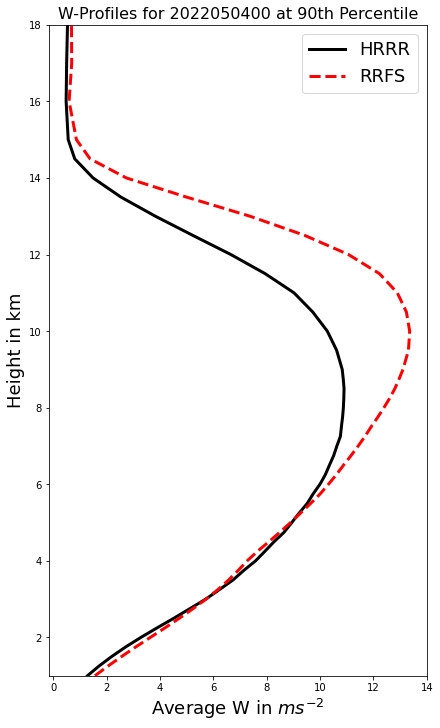

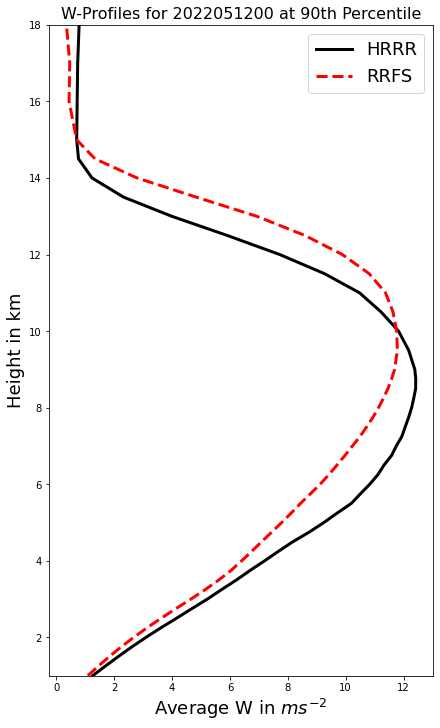

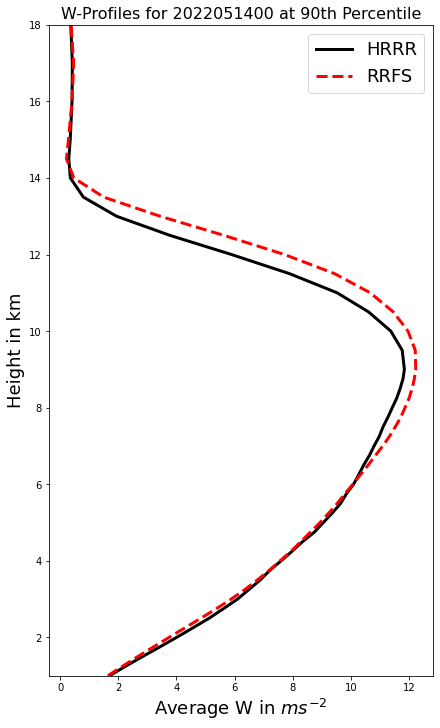

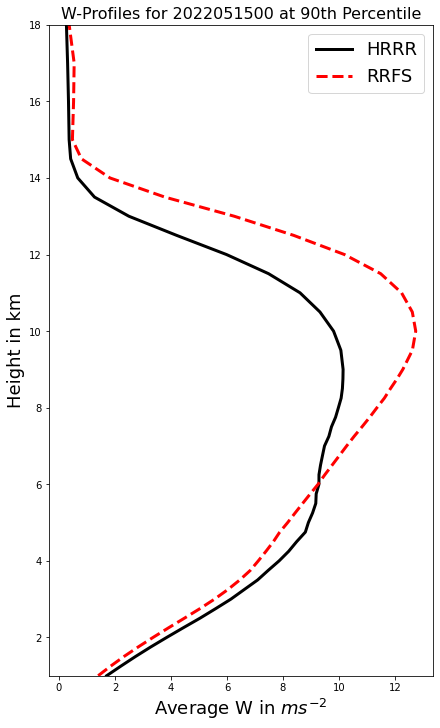

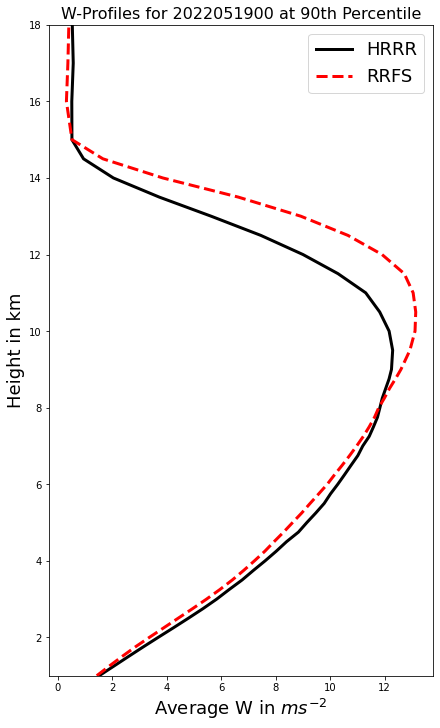

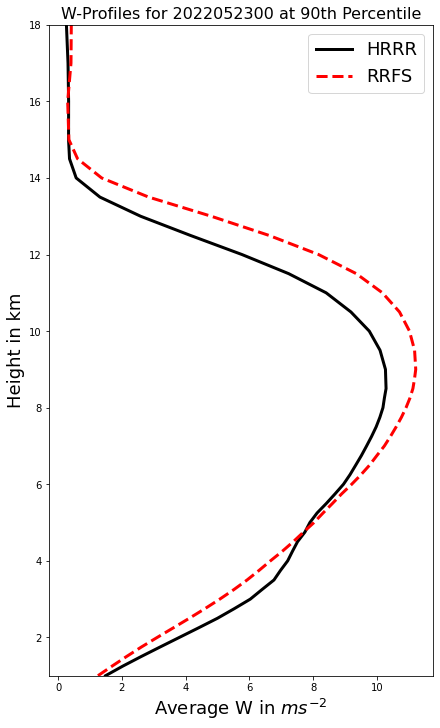

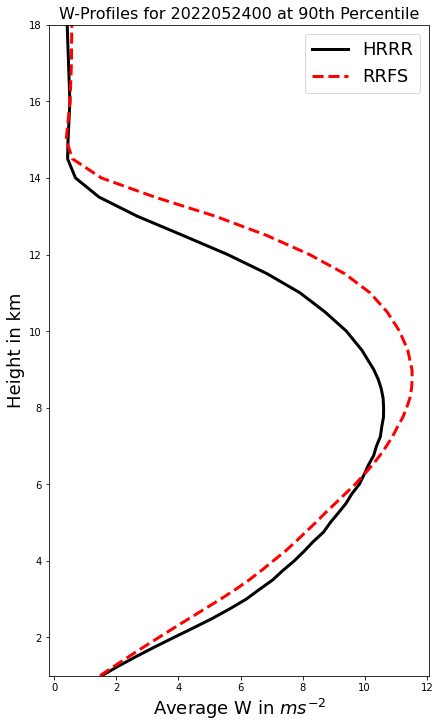

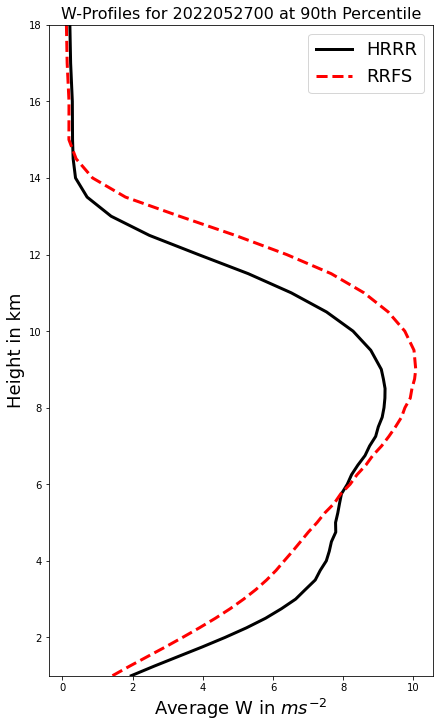

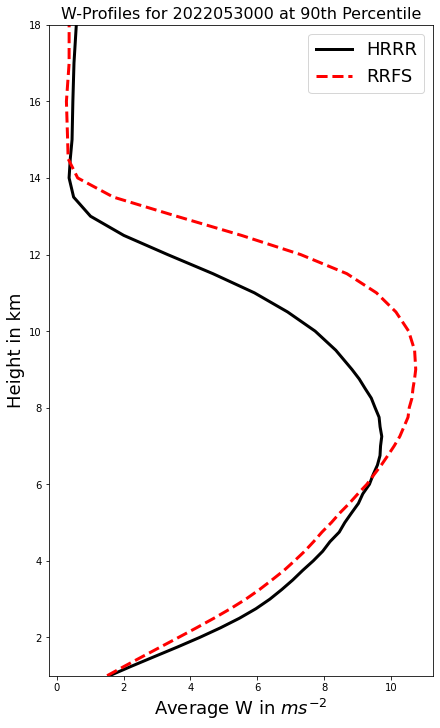

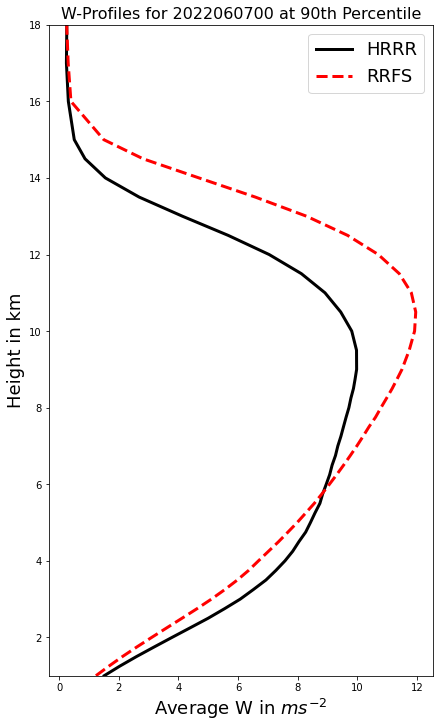

In [6]:
with open("hrrr_w_profiles.pkl", 'rb') as f:
    hrrr_profiles = pickle.load(f)
        
with open("rrfs_w_profiles.pkl", 'rb') as f:
    rrfs_profiles = pickle.load(f)        
        
percentile = 0.90

for n, data in enumerate(zip(hrrr_profiles, rrfs_profiles)):
    
    fig, ax = plt.subplots(1,1, constrained_layout=True,figsize=(6,10))

    idx = int(data[0].shape[1] * percentile)

    ax.plot(data[0][:,idx:].mean(axis=1), zlevels/1000., color='k', linewidth=3., label='HRRR')

    idx = int(data[1].shape[1] * percentile)
    ax.plot(data[1][:,idx:].mean(axis=1), zlevels/1000., color='r', linewidth=3., linestyle='--', label='RRFS')

    ax.set_ylim(1., 18.)
    ax.legend(fontsize=18)
    ax.set_title("W-Profiles for %s at %2.2dth Percentile" % (case_days[n], int(percentile*100)), fontsize=16)
    
    #ax.axvline(x=0.0, color='k', linestyle='--')
    ax.set_ylabel("Height in km", fontsize=18)
    ax.set_xlabel("Average W in $m s^{-2}$", fontsize=18)
    
    plt.show()

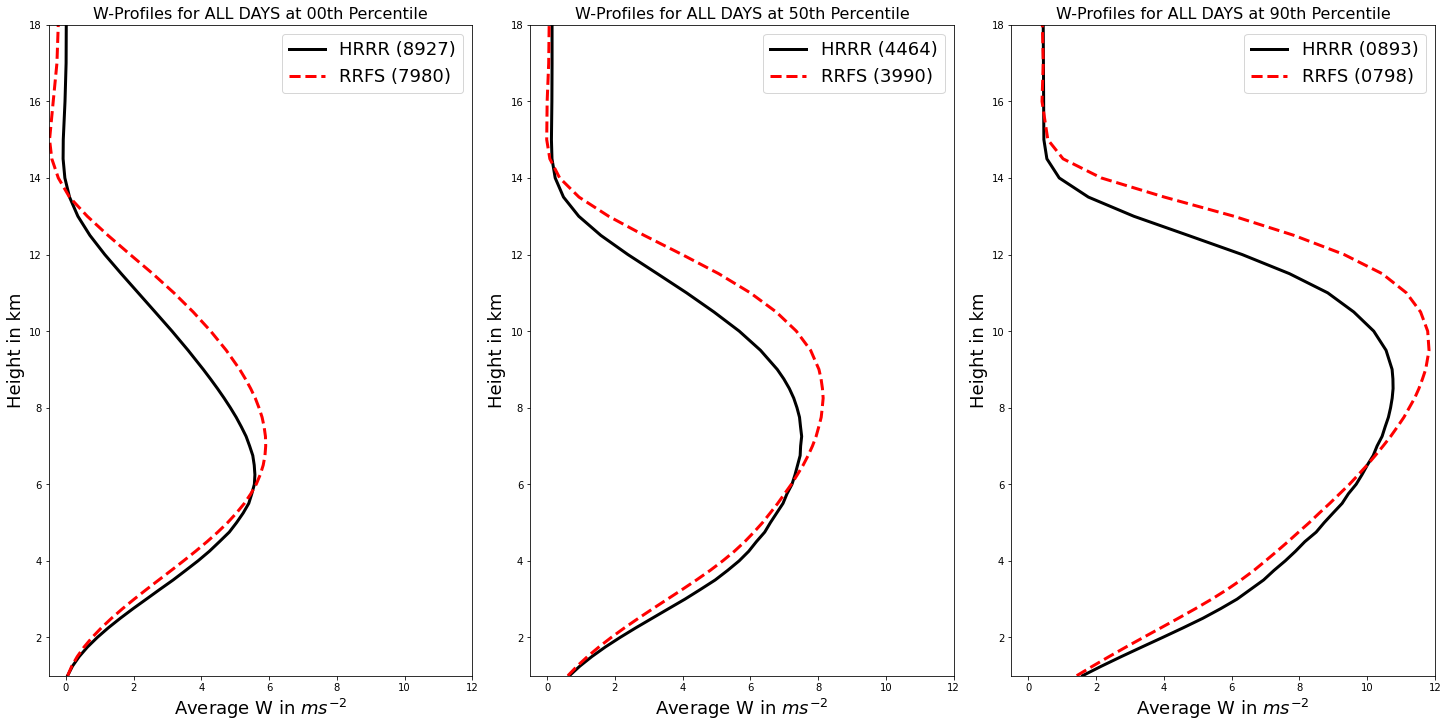

In [33]:
with open("hrrr_w_profiles.pkl", 'rb') as f:
    hrrr_profiles = pickle.load(f)
        
with open("rrfs_w_profiles.pkl", 'rb') as f:
    rrfs_profiles = pickle.load(f)        
        
percentile = [0.0, 0.5, 0.9]

hrrr_composite = []
rrfs_composite = []

for n, data in enumerate(zip(hrrr_profiles, rrfs_profiles)):
    
    hrrr_composite.append(data[0])
    rrfs_composite.append(data[1])

hrrr = np.concatenate(hrrr_composite, axis=1)
rrfs = np.concatenate(rrfs_composite, axis=1)

hrrr = np.sort(hrrr, axis=1)
rrfs = np.sort(rrfs, axis=1)

fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))

for n, p in enumerate(percentile):

    if p > 0.0:
        idx = int(hrrr.shape[1] * p)
        hrrr_Nobj = hrrr.shape[1] - idx
    else:
        idx = 0
        hrrr_Nobj = hrrr.shape[1]

    ax[n].plot(hrrr[:,idx:].mean(axis=1), zlevels/1000., color='k', linewidth=3., label='HRRR (%4.4d)' % hrrr_Nobj)

    if p > 0.0:
        idx = int(rrfs.shape[1] * p)
        rrfs_Nobj = rrfs.shape[1] - idx
    else:
        idx = 0
        rrfs_Nobj = rrfs.shape[1]
        
    ax[n].plot(rrfs[:,idx:].mean(axis=1), zlevels/1000., color='r', linewidth=3., linestyle='--', label='RRFS (%4.4d)' % rrfs_Nobj)

    ax[n].set_ylim(1., 18.)
    ax[n].set_xlim(-0.5, 12.)
    ax[n].legend(fontsize=18)
    ax[n].set_title("W-Profiles for %s at %2.2dth Percentile" % ("ALL DAYS", int(p*100)), fontsize=16)

    #ax.axvline(x=0.0, color='k', linestyle='--')
    ax[n].set_ylabel("Height in km", fontsize=18)
    ax[n].set_xlabel("Average W in $m s^{-2}$", fontsize=18)

plt.show()

In [40]:
print(rrfs.shape)
np.cumsum(rrfs, axis=0).shape

(49, 7980)


(49, 7980)